In [1]:
%matplotlib widget
from matplotlib import animation, rc
rc('animation', html='jshtml')
import matplotlib.pyplot as plt

# Synthesis for control
In this notebook we discuss disadvantages of the algorithm presented at CAV'2020 for control. The algorithm creates strategies that guarantee that some infinite-horizon objective will be fullfilled. However, it does not always generate strategies that would be reasonable. We demonstrate that on a concrete example and suggest simple heuristics that dramatically increase the quality of the generated strategies.

## Environment
We will consider a energy-dependent control with Büchi objective in a grid-world. We create the grid-worls simulator object of class `UUVEnv` by calling a wrapper function `env` stored in `environment.py`.

In [2]:
from environment import env, animate_strategy
capacity = 70
e = env(capacity)
m, targets = e.create_consmdp()

We will be visualising strategies using the following function. Here we show just the "game plan" for the agent. The agent (red) should repeatedly reach the green target state and can reload its energy in the brown states. The history of moves will be visualized using darker gray color.

In [3]:
animate_strategy({}, e, steps=1)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

The agent can go to the four directions `NORTH`, `SOUTH`, `WEST`, and `EAST`. It can pick a weak action that cost 1 unit of energy, but may be deviated to other directions. For example, picking `NORTH`, the agent can end-up going to `WEST` or `EAST` with a low probability (and never to `SOUTH`). A strong actions, that cost 2 units of energy do not have this deviation.

The following cell shows the probabilities of reaching successors of the state 42 when picking weak `NORTH` action. The states are numbered starting 0 in the left-top corner. Going north means decreasing the state-number by 20 (the horizontal dimension of the grid). Going `WEST` translates to $-1$ and going to `EAST` to $+1$.

In [4]:
m.actions[m.succ[42]].distr

{22: 0.861, 41: 0.049, 43: 0.09}

## The algorithm as presented in CAV paper
We solve the Büchi objective and simulate 100 steps of the generated strategy using the `animate_strategy` function.

In [5]:
from fimdp.energy_solver import EnergySolver, BUCHI

# Generate strategy
s = EnergySolver(m, cap=120, targets=targets)
strategy = s.get_strategy(BUCHI, recompute=True)

In [6]:
animate_strategy(strategy, e, 100)

We can observe that the agent does not proceed fast enough to the target. The reason for that can be seen in the strategy does ignore the probabilities of outcomes completely. It often picks the action `NORTH` and only a few times the agent actually moves right. The action `NORTH` has a possible outcome going `EAST` with very low probability. The reason why it is prefered to action `EAST` is that `NORTH` is the first action evaluated in each state.

## Pick most-likely successfull action heuristic
To fix the issue from above, we remember what is the probability of reaching the desired successor for each evaluated action (during computation of `action_value_T`) and then pick action with the lowest value, but also with the highest probability of reaching the desired successor. This is implemented in `EnergySolver_GoalLeaning` class.

In [7]:
from fimdp.energy_solver import EnergySolver_GoalLeaning

s = EnergySolver_GoalLeaning(m, cap=120, targets=targets)
strategy = s.get_strategy(BUCHI, recompute=True)

In [8]:
animate_strategy(strategy, e, 100)

In [9]:
m.actions[m.succ[42]].distr

{22: 0.861, 41: 0.049, 43: 0.09}

This strategy looks much better, but still it struggles to reach the target when in close proximity. This will be even more obvious if we change the transition probabilities in the environment and make the undesired outcomes less frequent by decreasing the `heading_sd` (standard deviation in true heading) parameter of the UUVEnv object.

In [10]:
e = env(capacity, heading_sd=0.32)
m, targets = e.create_consmdp()

m.actions[m.succ[42]].distr

{22: 0.983, 41: 0.003, 43: 0.014}

Now the agent does not manage to reach the target at all in the first steps.

In [11]:
s = EnergySolver_GoalLeaning(m, cap=120, targets=targets)
strategy = s.get_strategy(BUCHI, recompute=True)

animate_strategy(strategy, e, 100)

The reason for this is that if the agent picks `EAST` near the target, one possible outcome is going `SOUTH`. The state the is `SOUTH EAST` from the target has highest *value needed for survival (Safe)* then all other neighbours of the goal, and that causes the action value to be 1 energy unit higher than `NORTH`. The agent thus prefers `NORTH` and relies on the unlikely event of deviation from the picked direction.

## Goal leaning heurisitc with treshold
The reason why our algorithm does not chooses `EAST` is hidden in computing values needed for reachability that relies on the `action_value_T` function. The `action_value_T` for an action intuitivelly chooses a successor $t$ minimizing a maximum over:
 * the current energy value needed to reach goal (T) from $t$ (possibly via some reload state) for $t$, and
 * Safe values for the rest of the possible outcomes.
If several $t$ have the same value, the last heuristic chooses the one which is more likely to happen. For a state, we then pick the action with lowest `action_value_T` (and such that its desired $t$ is likely to happen). If a new value (lower) was achieved, we also update the corresponding strategy.

But as the previous example demonstrates, sometimes the action with the lowest `action_value_T` might not be the best choice. In our scenario, `EAST` has the `action_value_T(EAST)` 1 unit higher then `NORTH` (but here the target is reached with a very low probability). 

We can set a probability treshold, and keep track of 2 values for reachability in each state:
 1. **main energy level** needed to reach goal only by actions with desired outcome above the treshold
 2. **backup energy level** (can only be lower) that use some action with below-treshold probability for some action. We should use the backup energy level actions only for the lowest value in each state.

This heuristic should also handle cases like the one below (consider all actions having consumption 1 and not-listed probabilities are also 1, rel are reload states). The classical algorithm would choose the action that goes to the top state (even with the first heuristic). With the treshold being $\geq 0.01$ the desired strategy should go via the top path only with energy=1 (using the below-treshold value), otherwise it should prefer the bottom path.

In [14]:
import itikz
%load_ext itikz

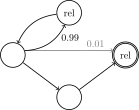

In [54]:
%%itikz --implicit-pic --temp-dir --tikz-libraries=automata
\begin{scope}[thick, every node/.style={state}]
\node[] (s0) at (0,0) {};
\node[] (s1) at (2,1.5) {rel};
\node[] (s2) at (2,-1.5) {};
\node[accepting] (s3) at (4, 0) {rel};
\end{scope}

\path[->,thick]
(s0.20) edge[gray] node[above, pos=.8]{0.01} (s3.160)
(s0.20) edge[bend right] node[right, pos=.7, outer sep=2pt] {0.99} (s1)
(s1) edge[bend right] (s0)
(s0) edge (s2)
(s2) edge (s3)
;